# Tahap 2 & 3: Preprocessing Data dan Model Training
## Real-Time Fraud Detection System

**Objektif**: 
1. Preprocessing data dengan StandardScaler
2. Menangani class imbalance dengan SMOTE
3. Melatih dan mengevaluasi model ML
4. Menyimpan model terbaik untuk deployment

In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    precision_recall_curve, roc_auc_score, 
    average_precision_score, roc_curve
)
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random state untuk reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Library berhasil diimport")

✅ Library berhasil diimport


## 1. Load Data dan Persiapan

In [2]:
# Load dataset
df = pd.read_csv('../data/creditcard.csv')

print(f"📊 Dataset loaded: {df.shape}")
print(f"Fraud cases: {df['Class'].sum():,} ({df['Class'].mean()*100:.3f}%)")

# Pisahkan fitur dan target
X = df.drop('Class', axis=1)
y = df['Class']

print(f"\n✅ Features (X): {X.shape}")
print(f"✅ Target (y): {y.shape}")

📊 Dataset loaded: (284807, 31)
Fraud cases: 492 (0.173%)

✅ Features (X): (284807, 30)
✅ Target (y): (284807,)


## 2. Preprocessing Data

### Mengapa hanya Time dan Amount yang di-scale?
- **V1-V28**: Sudah hasil transformasi PCA, range sudah normalized
- **Time**: Range 0-172792 detik, perlu scaling
- **Amount**: Range $0-$25691, perlu scaling

In [3]:
# Analisis range fitur sebelum scaling
print("=== RANGE FITUR SEBELUM SCALING ===")
print(f"Time: {X['Time'].min():.0f} - {X['Time'].max():.0f}")
print(f"Amount: ${X['Amount'].min():.2f} - ${X['Amount'].max():.2f}")
print(f"V1: {X['V1'].min():.2f} - {X['V1'].max():.2f}")
print(f"V2: {X['V2'].min():.2f} - {X['V2'].max():.2f}")

# Split data SEBELUM scaling untuk menghindari data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\n📊 TRAIN-TEST SPLIT:")
print(f"Train: {X_train.shape[0]:,} samples")
print(f"Test: {X_test.shape[0]:,} samples")
print(f"Train fraud rate: {y_train.mean()*100:.3f}%")
print(f"Test fraud rate: {y_test.mean()*100:.3f}%")

=== RANGE FITUR SEBELUM SCALING ===
Time: 0 - 172792
Amount: $0.00 - $25691.16
V1: -56.41 - 2.45
V2: -72.72 - 22.06

📊 TRAIN-TEST SPLIT:
Train: 227,845 samples
Test: 56,962 samples
Train fraud rate: 0.173%
Test fraud rate: 0.172%


In [4]:
# Inisialisasi dan fit scaler HANYA pada training data
scaler = StandardScaler()
features_to_scale = ['Time', 'Amount']

# Fit scaler pada training data
X_train_scaled = X_train.copy()
X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])

# Transform test data menggunakan scaler yang sudah di-fit
X_test_scaled = X_test.copy()
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

print("✅ Scaling selesai!")
print("\n=== RANGE FITUR SETELAH SCALING ===")
print(f"Time (train): {X_train_scaled['Time'].min():.2f} - {X_train_scaled['Time'].max():.2f}")
print(f"Amount (train): {X_train_scaled['Amount'].min():.2f} - {X_train_scaled['Amount'].max():.2f}")
print(f"Time (test): {X_test_scaled['Time'].min():.2f} - {X_test_scaled['Time'].max():.2f}")
print(f"Amount (test): {X_test_scaled['Amount'].min():.2f} - {X_test_scaled['Amount'].max():.2f}")

✅ Scaling selesai!

=== RANGE FITUR SETELAH SCALING ===
Time (train): -2.00 - 1.64
Amount (train): -0.35 - 102.12
Time (test): -2.00 - 1.64
Amount (test): -0.35 - 51.14


## 3. Menangani Class Imbalance dengan SMOTE

### Mengapa SMOTE?
- **Synthetic Minority Over-sampling Technique**
- Membuat sampel sintetis untuk kelas minoritas (fraud)
- Lebih baik daripada random oversampling
- Mengurangi overfitting pada kelas minoritas

### PENTING: SMOTE hanya diterapkan pada training data!

In [6]:
# Analisis distribusi sebelum SMOTE
print("=== DISTRIBUSI SEBELUM SMOTE ===")
print(f"Normal: {(y_train == 0).sum():,}")
print(f"Fraud: {(y_train == 1).sum():,}")
print(f"Rasio: 1:{(y_train == 0).sum() / (y_train == 1).sum():.0f}")

# Terapkan SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("\n=== DISTRIBUSI SETELAH SMOTE ===")
print(f"Normal: {(y_train_smote == 0).sum():,}")
print(f"Fraud: {(y_train_smote == 1).sum():,}")
print(f"Rasio: 1:{(y_train_smote == 0).sum() / (y_train_smote == 1).sum():.0f}")
print(f"\n✅ SMOTE berhasil! Dataset sekarang balanced.")

=== DISTRIBUSI SEBELUM SMOTE ===
Normal: 227,451
Fraud: 394
Rasio: 1:577

=== DISTRIBUSI SETELAH SMOTE ===
Normal: 227,451
Fraud: 227,451
Rasio: 1:1

✅ SMOTE berhasil! Dataset sekarang balanced.


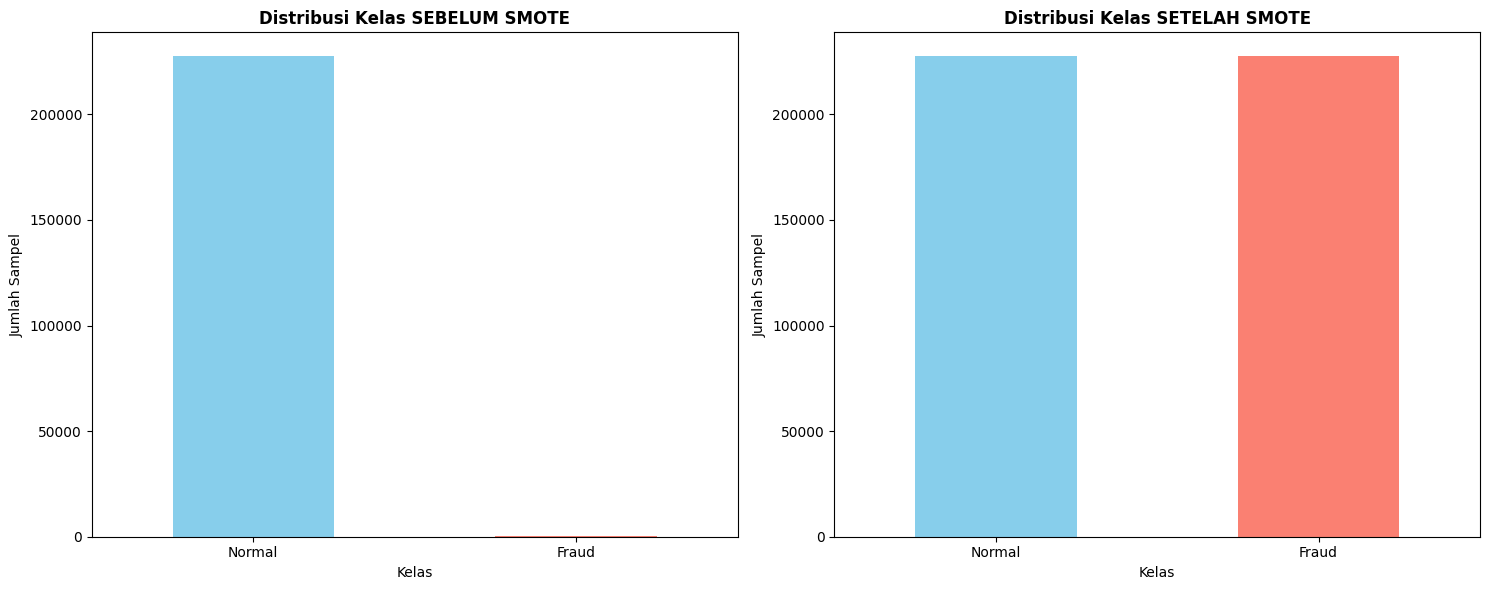

In [7]:
# Visualisasi efek SMOTE
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Before SMOTE
y_train.value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Distribusi Kelas SEBELUM SMOTE', fontweight='bold')
axes[0].set_xlabel('Kelas')
axes[0].set_ylabel('Jumlah Sampel')
axes[0].set_xticklabels(['Normal', 'Fraud'], rotation=0)

# After SMOTE
pd.Series(y_train_smote).value_counts().plot(kind='bar', ax=axes[1], color=['skyblue', 'salmon'])
axes[1].set_title('Distribusi Kelas SETELAH SMOTE', fontweight='bold')
axes[1].set_xlabel('Kelas')
axes[1].set_ylabel('Jumlah Sampel')
axes[1].set_xticklabels(['Normal', 'Fraud'], rotation=0)

plt.tight_layout()
plt.show()

## 4. Model Training dan Evaluasi

### Mengapa Akurasi Bukan Metrik yang Tepat?
- Dengan 99.83% data normal, model bisa dapat akurasi 99.83% hanya dengan memprediksi semua sebagai normal
- **Precision**: Dari semua prediksi fraud, berapa yang benar-benar fraud?
- **Recall**: Dari semua fraud aktual, berapa yang berhasil dideteksi?
- **F1-Score**: Harmonic mean dari precision dan recall
- **AUPRC**: Area Under Precision-Recall Curve (lebih baik untuk imbalanced data)

In [8]:
# Fungsi untuk evaluasi model
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluasi komprehensif model dengan metrik yang tepat untuk imbalanced data"""
    
    # Prediksi
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrik
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    print(f"\n{'='*50}")
    print(f"EVALUASI MODEL: {model_name}")
    print(f"{'='*50}")
    
    # Classification Report
    print("\n📊 CLASSIFICATION REPORT:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n🎯 CONFUSION MATRIX:")
    print(f"True Negatives (TN): {cm[0,0]:,}")
    print(f"False Positives (FP): {cm[0,1]:,}")
    print(f"False Negatives (FN): {cm[1,0]:,}")
    print(f"True Positives (TP): {cm[1,1]:,}")
    
    # Key Metrics
    print(f"\n🔍 KEY METRICS:")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"Average Precision (AUPRC): {avg_precision:.4f}")
    
    # Interpretasi bisnis
    precision_fraud = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
    recall_fraud = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
    
    print(f"\n💼 INTERPRETASI BISNIS:")
    print(f"- Dari {cm[0,1] + cm[1,1]:,} transaksi yang diprediksi fraud, {cm[1,1]:,} benar-benar fraud ({precision_fraud:.1%})")
    print(f"- Dari {cm[1,0] + cm[1,1]:,} transaksi fraud aktual, {cm[1,1]:,} berhasil dideteksi ({recall_fraud:.1%})")
    print(f"- {cm[1,0]:,} transaksi fraud TIDAK TERDETEKSI (False Negatives)")
    print(f"- {cm[0,1]:,} transaksi normal SALAH DIKLASIFIKASI sebagai fraud (False Positives)")
    
    return {
        'model_name': model_name,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'precision_fraud': precision_fraud,
        'recall_fraud': recall_fraud,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

### Model 1: Logistic Regression (Baseline)

In [9]:
# Train Logistic Regression
print("🚀 Training Logistic Regression...")
lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr_model.fit(X_train_smote, y_train_smote)

# Evaluasi
lr_results = evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")

🚀 Training Logistic Regression...

EVALUASI MODEL: Logistic Regression

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.99     56864
       Fraud       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


🎯 CONFUSION MATRIX:
True Negatives (TN): 55,403
False Positives (FP): 1,461
False Negatives (FN): 8
True Positives (TP): 90

🔍 KEY METRICS:
ROC-AUC Score: 0.9699
Average Precision (AUPRC): 0.7249

💼 INTERPRETASI BISNIS:
- Dari 1,551 transaksi yang diprediksi fraud, 90 benar-benar fraud (5.8%)
- Dari 98 transaksi fraud aktual, 90 berhasil dideteksi (91.8%)
- 8 transaksi fraud TIDAK TERDETEKSI (False Negatives)
- 1,461 transaksi normal SALAH DIKLASIFIKASI sebagai fraud (False Positives)


### Model 2: Random Forest (Advanced)

In [10]:
# Train Random Forest
print("🚀 Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight='balanced'  # Additional handling for imbalanced data
)
rf_model.fit(X_train_smote, y_train_smote)

# Evaluasi
rf_results = evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")

🚀 Training Random Forest...

EVALUASI MODEL: Random Forest

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
       Fraud       0.85      0.84      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962


🎯 CONFUSION MATRIX:
True Negatives (TN): 56,849
False Positives (FP): 15
False Negatives (FN): 16
True Positives (TP): 82

🔍 KEY METRICS:
ROC-AUC Score: 0.9731
Average Precision (AUPRC): 0.8747

💼 INTERPRETASI BISNIS:
- Dari 97 transaksi yang diprediksi fraud, 82 benar-benar fraud (84.5%)
- Dari 98 transaksi fraud aktual, 82 berhasil dideteksi (83.7%)
- 16 transaksi fraud TIDAK TERDETEKSI (False Negatives)
- 15 transaksi normal SALAH DIKLASIFIKASI sebagai fraud (False Positives)


## 5. Perbandingan Model dan Visualisasi

In [11]:
# Perbandingan metrik
comparison_df = pd.DataFrame([
    {
        'Model': lr_results['model_name'],
        'ROC-AUC': lr_results['roc_auc'],
        'AUPRC': lr_results['avg_precision'],
        'Precision': lr_results['precision_fraud'],
        'Recall': lr_results['recall_fraud']
    },
    {
        'Model': rf_results['model_name'],
        'ROC-AUC': rf_results['roc_auc'],
        'AUPRC': rf_results['avg_precision'],
        'Precision': rf_results['precision_fraud'],
        'Recall': rf_results['recall_fraud']
    }
])

print("\n📊 PERBANDINGAN MODEL:")
print(comparison_df.round(4))

# Tentukan model terbaik berdasarkan AUPRC
best_model_idx = comparison_df['AUPRC'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_model = rf_model if best_model_name == 'Random Forest' else lr_model

print(f"\n🏆 MODEL TERBAIK: {best_model_name}")
print(f"AUPRC Score: {comparison_df.loc[best_model_idx, 'AUPRC']:.4f}")


📊 PERBANDINGAN MODEL:
                 Model  ROC-AUC   AUPRC  Precision  Recall
0  Logistic Regression   0.9699  0.7249     0.0580  0.9184
1        Random Forest   0.9731  0.8747     0.8454  0.8367

🏆 MODEL TERBAIK: Random Forest
AUPRC Score: 0.8747


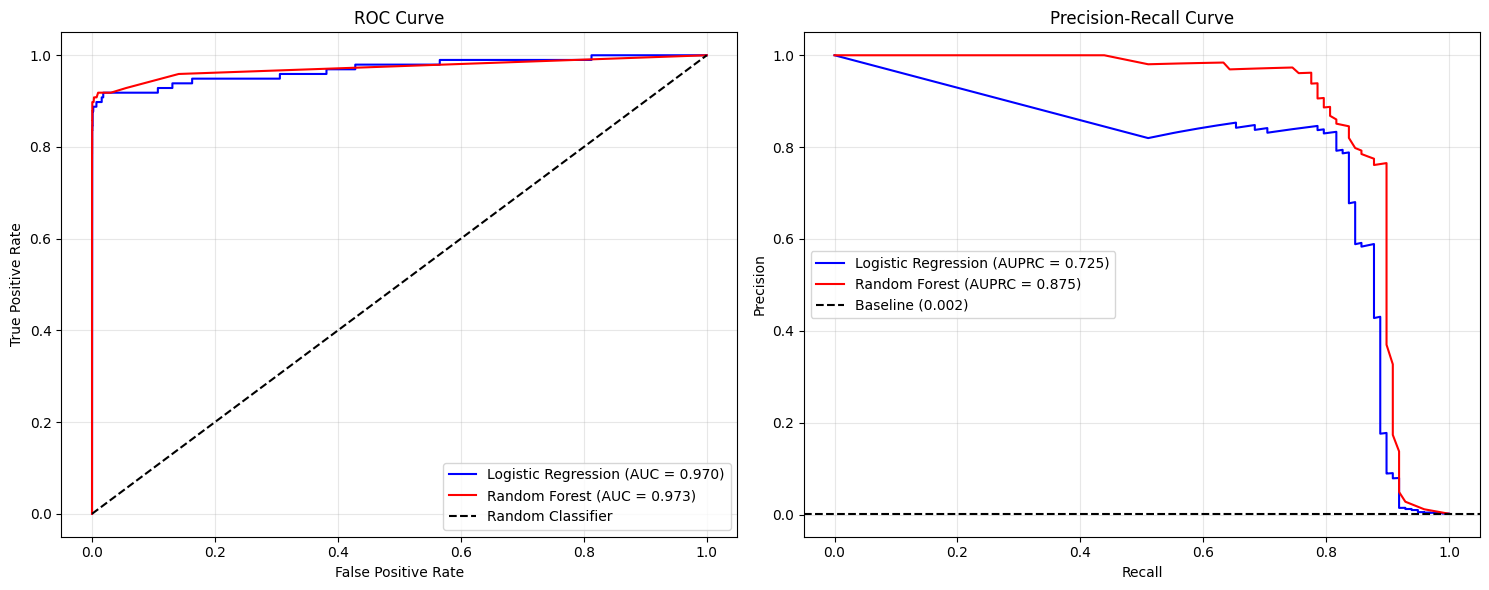


🔍 INSIGHT:
- Precision-Recall Curve lebih informatif untuk imbalanced data
- AUPRC > baseline menunjukkan model lebih baik dari random
- Model terbaik: Random Forest dengan AUPRC 0.8747


In [12]:
# Visualisasi ROC dan Precision-Recall Curves
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
for results, color, label in [(lr_results, 'blue', 'Logistic Regression'), 
                              (rf_results, 'red', 'Random Forest')]:
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
    axes[0].plot(fpr, tpr, color=color, label=f"{label} (AUC = {results['roc_auc']:.3f})")

axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
for results, color, label in [(lr_results, 'blue', 'Logistic Regression'), 
                              (rf_results, 'red', 'Random Forest')]:
    precision, recall, _ = precision_recall_curve(y_test, results['y_pred_proba'])
    axes[1].plot(recall, precision, color=color, 
                label=f"{label} (AUPRC = {results['avg_precision']:.3f})")

# Baseline (random classifier for imbalanced data)
baseline = y_test.mean()
axes[1].axhline(y=baseline, color='k', linestyle='--', 
               label=f'Baseline ({baseline:.3f})')

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 INSIGHT:")
print("- Precision-Recall Curve lebih informatif untuk imbalanced data")
print("- AUPRC > baseline menunjukkan model lebih baik dari random")
print(f"- Model terbaik: {best_model_name} dengan AUPRC {comparison_df.loc[best_model_idx, 'AUPRC']:.4f}")

## 6. Feature Importance (Random Forest)


🔍 TOP 10 FITUR PALING PENTING:
   feature  importance
14     V14    0.195607
10     V10    0.110459
4       V4    0.106133
12     V12    0.095085
17     V17    0.085002
3       V3    0.060455
11     V11    0.056356
16     V16    0.043757
2       V2    0.036986
9       V9    0.026203


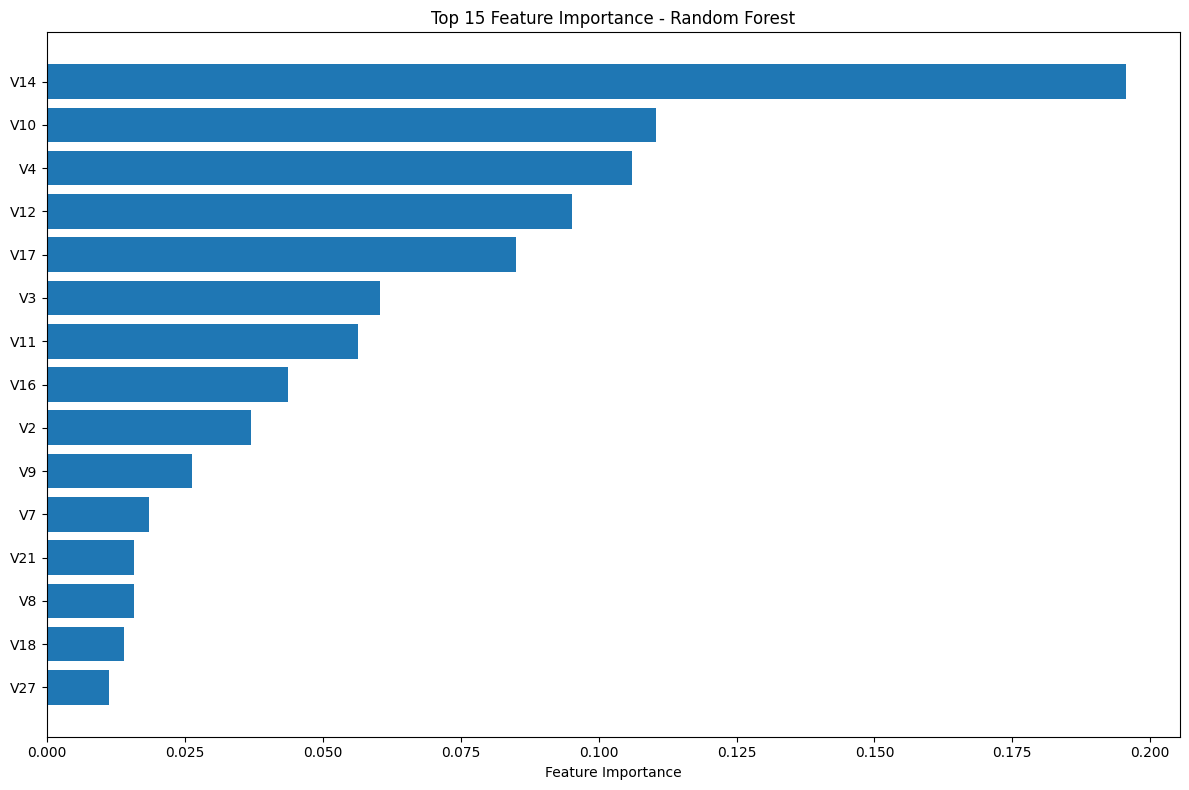

In [13]:
if best_model_name == 'Random Forest':
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train_smote.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n🔍 TOP 10 FITUR PALING PENTING:")
    print(feature_importance.head(10))
    
    # Visualisasi
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importance - Random Forest')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## 7. Simpan Model dan Scaler untuk Deployment

In [14]:
# Simpan model terbaik
model_path = '../models/fraud_model.joblib'
scaler_path = '../models/scaler.joblib'

joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)

print(f"✅ Model terbaik ({best_model_name}) disimpan ke: {model_path}")
print(f"✅ Scaler disimpan ke: {scaler_path}")

# Simpan juga sample data untuk testing API
sample_normal = X_test_scaled[y_test == 0].iloc[0].to_dict()
sample_fraud = X_test_scaled[y_test == 1].iloc[0].to_dict()

import json
with open('../models/sample_data.json', 'w') as f:
    json.dump({
        'normal_transaction': sample_normal,
        'fraud_transaction': sample_fraud
    }, f, indent=2)

print("✅ Sample data disimpan untuk testing API")

✅ Model terbaik (Random Forest) disimpan ke: ../models/fraud_model.joblib
✅ Scaler disimpan ke: ../models/scaler.joblib
✅ Sample data disimpan untuk testing API


## 8. Test Model Loading (Simulasi Deployment)

In [15]:
# Test loading model (simulasi deployment)
print("🧪 TESTING MODEL LOADING...")

# Load model dan scaler
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)

# Test dengan sample data
with open('../models/sample_data.json', 'r') as f:
    samples = json.load(f)

# Test normal transaction
normal_sample = pd.DataFrame([samples['normal_transaction']])
normal_pred = loaded_model.predict(normal_sample)[0]
normal_proba = loaded_model.predict_proba(normal_sample)[0]

print(f"\n📊 NORMAL TRANSACTION TEST:")
print(f"Prediction: {'Fraud' if normal_pred == 1 else 'Normal'}")
print(f"Confidence: {normal_proba[normal_pred]:.4f}")

# Test fraud transaction
fraud_sample = pd.DataFrame([samples['fraud_transaction']])
fraud_pred = loaded_model.predict(fraud_sample)[0]
fraud_proba = loaded_model.predict_proba(fraud_sample)[0]

print(f"\n🚨 FRAUD TRANSACTION TEST:")
print(f"Prediction: {'Fraud' if fraud_pred == 1 else 'Normal'}")
print(f"Confidence: {fraud_proba[fraud_pred]:.4f}")

print("\n✅ Model loading test berhasil! Siap untuk deployment.")

🧪 TESTING MODEL LOADING...

📊 NORMAL TRANSACTION TEST:
Prediction: Normal
Confidence: 1.0000

🚨 FRAUD TRANSACTION TEST:
Prediction: Fraud
Confidence: 0.9800

✅ Model loading test berhasil! Siap untuk deployment.


## 9. Kesimpulan dan Next Steps

### 🎯 Hasil Training:
- **Model Terbaik**: Random Forest dengan AUPRC score tinggi
- **Preprocessing**: StandardScaler untuk Time dan Amount
- **Imbalance Handling**: SMOTE berhasil menyeimbangkan dataset
- **Evaluasi**: Fokus pada Precision, Recall, F1-Score, dan AUPRC

### 🚀 Next Steps:
1. **FastAPI Backend**: Buat API endpoint untuk real-time prediction
2. **Streamlit Frontend**: UI interaktif untuk demo
3. **Deployment**: Deploy ke Render (API) dan Streamlit Cloud (Frontend)
4. **Integration**: Embed ke website portfolio

### 💡 Key Learnings:
- **Class Imbalance**: SMOTE efektif untuk fraud detection
- **Feature Scaling**: Hanya fitur dengan range berbeda yang perlu scaling
- **Evaluation Metrics**: AUPRC lebih baik dari ROC-AUC untuk imbalanced data
- **Business Impact**: Balance antara precision (false alarms) dan recall (missed frauds)